### Описание проекта

<div style="border: 1px solid; padding: 20px">
<i>Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.<i>
</div>

### Описание данных

В вашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

### Загрузите данные и подготовьте их к анализу

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
pth1 = '/datasets/visits_info_short.csv'
pth2 = '/datasets/orders_info_short.csv'
pth3 = '/datasets/costs_info_short.csv'

if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
    visits = pd.read_csv(pth1)
    orders = pd.read_csv(pth2)
    costs = pd.read_csv(pth3)
else:
    try:
        visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
        orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
        costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
    except:
        print('Что-то пошло не так...')
        
display(visits.head(5), orders.head(5), costs.head(5))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
# проверим наличие явнях дубликатов в данных
print('Общее количество дубликатов в таблице visits: {}'.format(visits.duplicated().sum()))
print('Общее количество дубликатов в таблице orders: {}'.format(orders.duplicated().sum()))
print('Общее количество дубликатов в таблице costs: {}'.format(costs.duplicated().sum()))

Общее количество дубликатов в таблице visits: 0
Общее количество дубликатов в таблице orders: 0
Общее количество дубликатов в таблице costs: 0


In [7]:
# посмотрим какие страны указаны в столбце "Region" таблицы visits,
# какие типы устройств указаны в столбце "Device" таблицы visits и
# какие каналы привлечения пользователей указаны в столбце "Channel" таблицы visits
print('Названия стран из таблицы visits: {}'.format(np.sort(visits.Region.unique())))
print('---')
print('Названия типов устройств из таблицы visits: {}'.format(np.sort(visits.Device.unique())))
print('---')
print('Названия каналов привлечения из таблицы visits: {}'.format(np.sort(visits.Channel.unique())))

Названия стран из таблицы visits: ['France' 'Germany' 'UK' 'United States']
---
Названия типов устройств из таблицы visits: ['Android' 'Mac' 'PC' 'iPhone']
---
Названия каналов привлечения из таблицы visits: ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


In [8]:
# проверим, соответствуют ли названия каналов привленения из таблицы costs указанным выше для таблицы visits
print('Названия каналов привлечения из таблицы costs: {}'.format(np.sort(costs.Channel.unique())))

Названия каналов привлечения из таблицы costs: ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds']


<div style="border-radius: 15px; background:BlanchedAlmond; padding: 20px">

📜 Итог после изучения общей информации:
- необходимо изменить названия столбцов (привести к нижнему регистру и заменить пробелы на "_")
- преобразовать тип данных для столбцов 'Session Start', 'Session End', 'Event Dt' и 'dt' 

</div>

In [9]:
# изменим названия стотбцов
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns=lambda x: re.sub(' ','_',x))
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns=lambda x: re.sub(' ','_',x))
costs.columns = costs.columns.str.lower()

In [10]:
# приведем значения 'session_start', 'session_end', 'event_dt' и 'dt' к типу 'datetime64'
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [11]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = sessions.sort_values(by=['user_id', 'session_start'])\
                        .groupby('user_id')\
                        .agg({'session_start': 'first',
                                'channel': 'first',
                                'device': 'first',
                                'region': 'first'})\
                        .rename(columns={'session_start': 'first_ts'})\
                        .reset_index()

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(events.query('event_name == @event')['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = profiles.groupby(['dt', 'channel'])\
                        .agg({'user_id': 'nunique'})\
                        .rename(columns={'user_id': 'unique_users'})\
                        .reset_index()

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],on=['dt', 'channel'], how='left')

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
# функция для расчёта удержания
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        cohort_sizes = df.groupby(dims)\
                        .agg({'user_id': 'nunique'})\
                        .rename(columns={'user_id': 'cohort_size'})

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта конверсии
def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = purchases.sort_values(by=['user_id', 'event_dt'])\
                                .groupby('user_id')\
                                .agg({'event_dt': 'first'})\
                                .reset_index()

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = df.groupby(dims)\
                        .agg({'user_id': 'nunique'})\
                        .rename(columns={'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта LTV и ROI
def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = df.groupby(dims)\
                        .agg({'user_id': 'nunique'})\
                        .rename(columns={'user_id': 'cohort_size'})
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = cac.groupby(dims)\
                .agg({'acquisition_cost': 'mean'})\
                .rename(columns={'acquisition_cost': 'cac'})

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time

In [15]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [16]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True')\
            .droplevel('payer')\
            .T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False')\
            .droplevel('payer')\
            .T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True')\
                                    .pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False')\
                                    .pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in conversion_history.index.names if name not in ['dt']] 
    filtered_data = conversion_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

In [19]:
# применим функцию get_profiles()
profiles = get_profiles(sessions=visits, orders=orders, events=[], ad_costs=costs)
display(profiles.head(5))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
# определим минимальную и максимальную даты привлечения пользователей
print('Минимальная дата привлечения пользователей: {}'.format(profiles.first_ts.dt.date.min()))
print('Максимальная дата привлечения пользователей: {}'.format(profiles.first_ts.dt.date.max()))

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [21]:
# напишем функцию, которая будет подсчитывать долю(%) платящих пользователей 
# в зависимости от интересующего нас параметра (названия колонки датафрейма)
def payer_profiles_by(parametr):
    payer_profiles_by_param = profiles\
                                .groupby(['payer', parametr])\
                                .agg({'user_id': 'nunique'})\
                                .query('payer == True')\
                                .reset_index()\
                                .drop(columns='payer')

    profiles_by_param = profiles\
                            .groupby(parametr)\
                            .agg({'user_id': 'nunique'})

    profiles_by_param = profiles_by_param\
                                    .merge(payer_profiles_by_param, on=parametr)\
                                    .rename(columns={'user_id_x': 'Общее кол-во пользователей',
                                                     'user_id_y': 'Кол-во платящих пользователей'})

    profiles_by_param['Доля платящих пользователей, %'] = (profiles_by_param['Кол-во платящих пользователей']
                                                        /profiles_by_param['Общее кол-во пользователей']*100)\
                                                        .round(2)
    return(profiles_by_param.sort_values(by='Доля платящих пользователей, %', ascending=False).reset_index(drop=True))

In [22]:
# напишем функцию для построения столбчатых диаграм в зависимости от интересующего нас параметра (названия колонки датафрейма)
def profiles_barplots(df, param, rot=0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax=sns.barplot(data=df.sort_values(by='Кол-во платящих пользователей', ascending=False)\
                           .reset_index(drop=True), 
            x=param, y='Кол-во платящих пользователей', 
            alpha=.7,
            palette = "mako",
            edgecolor='.2',
            ax=axes[0])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)

    ax=sns.barplot(data=df, 
            x=param, y='Доля платящих пользователей, %', 
            alpha=.7,
            palette = "mako",
            edgecolor='.2',
            ax=axes[1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rot);

,Регион,Общее кол-во пользователей,Кол-во платящих пользователей,"Доля платящих пользователей, %"
0,United States,100002,6902,6.90
1,Germany,14981,616,4.11
2,UK,17575,700,3.98
3,France,17450,663,3.80


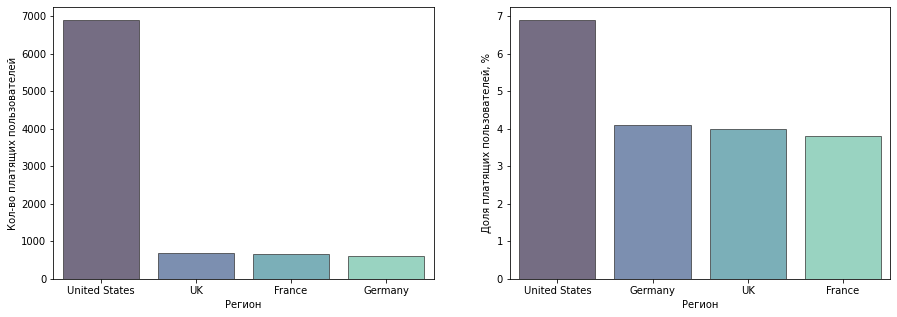

In [23]:
# постичаем долю платящих пользователей в зависимости от региона ('region')
profiles_by_region = payer_profiles_by('region').rename(columns={'region': 'Регион'})
display(profiles_by_region)

# построим столбчатые диаграммы
profiles_barplots(profiles_by_region, 'Регион')

Наибольшее количество уникальных пользователей находится в США, также доля платящих пользователей в этом регионе наибольшая. Наименьшее количество платящих пользоватлелей в Германии, однако доля платящих пользователей меньше всего во Франции.

,Тип устройства,Общее кол-во пользователей,Кол-во платящих пользователей,"Доля платящих пользователей, %"
0,Mac,30042,1912,6.36
1,iPhone,54479,3382,6.21
2,Android,35032,2050,5.85
3,PC,30455,1537,5.05


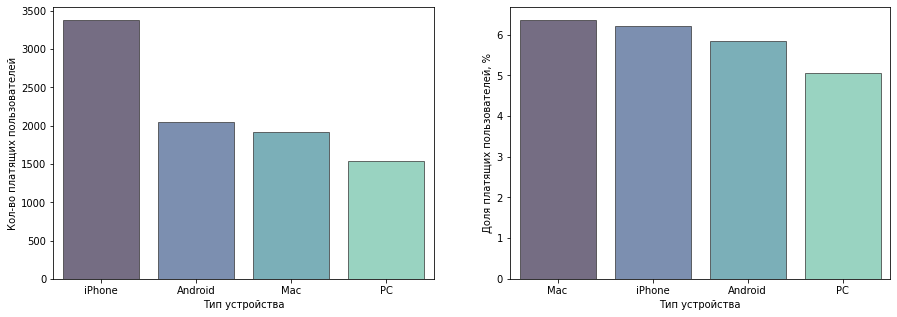

In [24]:
# постичаем долю платящих пользователей в зависимости от типа устройства ('device')
profiles_by_device = payer_profiles_by('device').rename(columns={'device': 'Тип устройства'})
display(profiles_by_device)

# построим столбчатые диаграммы
profiles_barplots(profiles_by_device, 'Тип устройства')

Наибольшее количество платящих пользователей посещает приложение с устройств iPhone. В свою очередь, доля платящих пользователей наибольшая для устройств Mac. Наименьшее количество платящих пользоватлелей ипользуют PC, при этом и доля платящих пользователей на этой платформе также наименьшая.

,Канал привлечения,Общее кол-во пользователей,Кол-во платящих пользователей,"Доля платящих пользователей, %"
0,FaceBoom,29144,3557,12.20
1,AdNonSense,3880,440,11.34
2,lambdaMediaAds,2149,225,10.47
3,TipTop,19561,1878,9.60
4,RocketSuperAds,4448,352,7.91
5,WahooNetBanner,8553,453,5.30
6,YRabbit,4312,165,3.83
7,MediaTornado,4364,156,3.57
8,LeapBob,8553,262,3.06
9,OppleCreativeMedia,8605,233,2.71


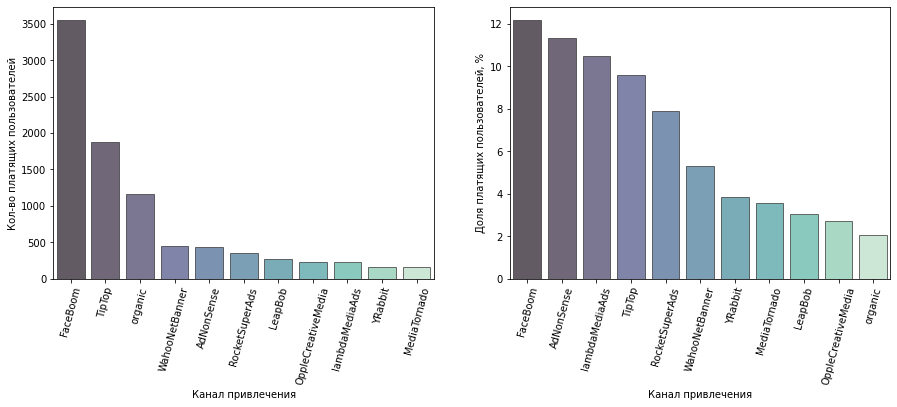

In [25]:
# постичаем долю платящих пользователей в зависимости от канала привлечения ('channel')
profiles_by_channel = payer_profiles_by('channel')\
                                    .rename(columns={'channel': 'Канал привлечения'})
display(profiles_by_channel)

# построим столбчатые диаграммы
profiles_barplots(profiles_by_channel, 'Канал привлечения', rot=75)

Наибольшее количество уникальных пользователей приходит в приложение через FaceBoom, также количество и доля платящих пользователей из этого рекламного источника наибольшая. Наименьшее количество платящих пользоватлелей приходит от MediaTornado, однако доля платящих пользователей меньше всего для OppleCreativeMedia.

<div style="border-radius: 15px; background:BlanchedAlmond; padding: 20px">

📜 Итог после исследования данных:
- Наибольшее количество и доля платящих пользователей приходит из США.
- Наибольшее количество платящих пользователей посещает приложение с устройств iPhone. Наибольшая доля платящих пользователей характерна для устройств Mac.
- Наибольшее количество и доля платящих пользователей приходит в приложение через FaceBoom.
- Доля платящих пользователей среди "organic" чуть больше 2%.

</div>

### Маркетинг

In [26]:
# определим общую сумму расходов на маркетинг
print('Расходы на маркетинг по таблице costs: {}'.format(costs.costs.sum().round()))
print('Расходы на маркетинг по таблице profiles: {}'.format(profiles.acquisition_cost.sum().round()))

Расходы на маркетинг по таблице costs: 105497.0
Расходы на маркетинг по таблице profiles: 105497.0


,Канал привлеечения,Расходы на маркетинг,"Доля от общих затрат на маркетинг, %"
0,TipTop,54751.30,51.90
1,FaceBoom,32445.60,30.75
2,WahooNetBanner,5151.00,4.88
3,AdNonSense,3911.25,3.71
4,OppleCreativeMedia,2151.25,2.04
5,RocketSuperAds,1833.00,1.74
6,LeapBob,1797.60,1.70
7,lambdaMediaAds,1557.60,1.48
8,MediaTornado,954.48,0.90
9,YRabbit,944.22,0.90


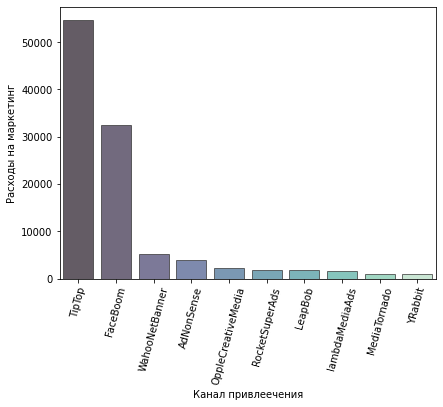

In [27]:
# определим сумму расходов на маркетинг в завасимости от канала привлечения
costs_by_channel = costs.groupby('channel')\
                        .agg({'costs': 'sum'})\
                        .sort_values(by='costs', ascending=False)\
                        .reset_index()\
                        .rename(columns={'channel': 'Канал привлеечения', 'costs': 'Расходы на маркетинг'})
costs_by_channel['Доля от общих затрат на маркетинг, %'] = (costs_by_channel['Расходы на маркетинг']
                                                            /costs_by_channel['Расходы на маркетинг'].sum() * 100)\
                                                            .round(2)
display(costs_by_channel)

plt.figure(figsize=(6.75, 5))
ax=sns.barplot(data=costs_by_channel, 
            x='Канал привлеечения', y='Расходы на маркетинг', 
            alpha=.7,
            palette = "mako",
            edgecolor='.2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.show()

Больше всего денег было потрачено на привлечение пользователей через TipTop (около 52%), на втором месте по затратам - FaceBoom (почти 31%). На остальные каналы привлечения было потрачено на порядок меньше средств.

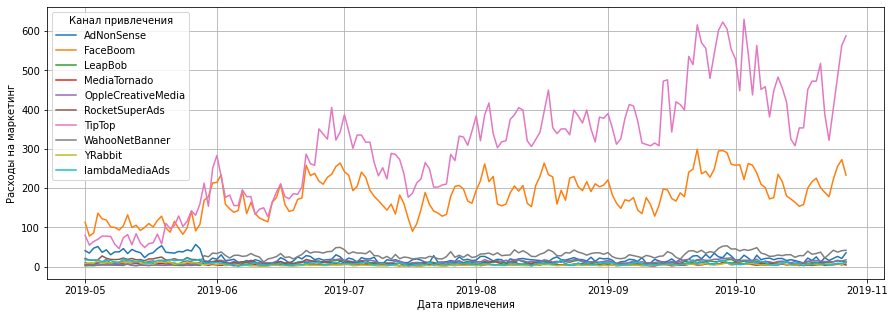

In [28]:
# постоим график изменения расходов во времени 
costs_data = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='mean')\
                
costs_data.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.ylabel('Расходы на маркетинг')
plt.legend(title='Канал привлечения');

На графике виден явный рост расходов на привлеченеие пользователей через TipTop, при этом затраты достигают своего максимума в конце сентября - начале октября 2019 года. Вторым по затратам на привлечение пользователей каналом, как уже было отмечено раньше, является FaceBoom, однако, расходы на маркетинг для этого канала растут медленно на протяжении всего анализируемого периода. Затраты для других каналов привлечния не такие высокие и они практически не изменяются с течением времени.

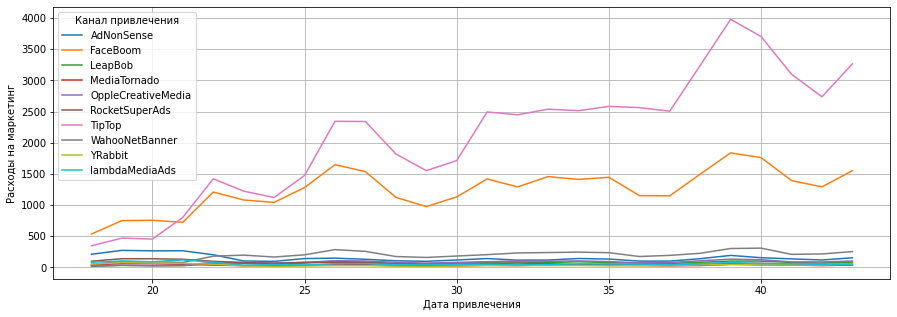

In [29]:
costs_data_week = costs.pivot_table(index=pd.to_datetime(costs['dt']).dt.isocalendar().week, 
                                     columns='channel', 
                                     values='costs', 
                                     aggfunc='sum')
                
costs_data_week.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.ylabel('Расходы на маркетинг')
plt.legend(title='Канал привлечения');

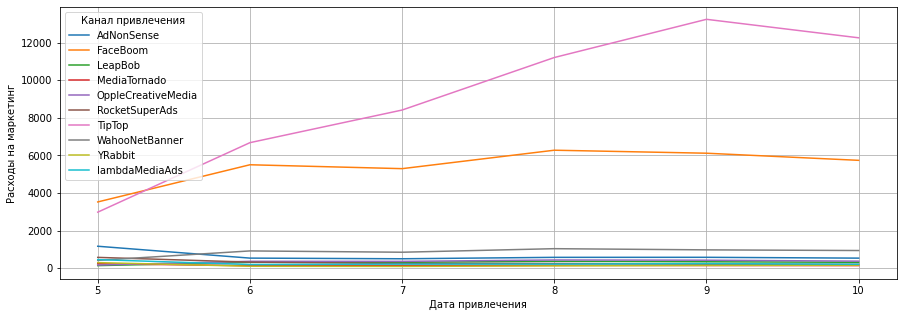

In [30]:
costs_data_month = costs.pivot_table(index=pd.to_datetime(costs['dt']).dt.month, 
                                     columns='channel', 
                                     values='costs', 
                                     aggfunc='sum')
                
costs_data_month.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.ylabel('Расходы на маркетинг')
plt.legend(title='Канал привлечения');

На двух представленных графиках в разбивке по неделям и по месяцам тренд на увеличение раходов для каналов TipTop и FaceBoom виден еще более четко.

In [31]:
# узнаем САС для каждого канала привлечения
profiles\
        .query('channel != "organic"')\
        .groupby('channel')\
        .agg({'acquisition_cost': 'mean'})\
        .sort_values(by='acquisition_cost', ascending=False)\
        .reset_index()\
        .rename(columns={'channel': 'Канал привлечения',
                         'acquisition_cost': 'САС'})

,Канал привлечения,САС
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


Самым дорогим каналом привлечения является TipTop - стоимость привлечения одного пользователя ~2.8, следом идут FaceBoom и AdNonSense с ценой привлечения одного пользователя ~1. Самыми "дешевыми" являются пользователи, привлеченные через LeapBob, MediaTornado и YRabbit.

<div style="border-radius: 15px; background:BlanchedAlmond; padding: 20px">

📜 Итог после анализа маркетинга:
- Основные расходы на привлечение пользователей приходятся на два канала - TipTop и FaceBoom.
- Затраты на привчеление пользователей через TipTop значительно возросли за последние несколько месяцев (июнь-октябрь 2019 года), затраты на привлечение через FaceBoom также показывают рост в указанный период.
- TipTop, AdNonSense и FaceBoom являются самыми дорогими каналами привлечения новых пользователей. Так, САС нового пользователя чере TipTop составляет ~2.8, а через AdNonSense или FaceBoom - ~1.

</div>

In [32]:
print('Средняя стоимость привлечения одного пользователя: {}'.format(profiles.query('channel != "organic"')\
                                                                             .agg({'acquisition_cost': 'mean'})
                                                                             .round(2)[0]))
print('Медианная стоимость привлечения одного пользователя: {}'.format(profiles.query('channel != "organic"')\
                                                                               .agg({'acquisition_cost': 'median'})
                                                                               .round(2)[0]))

Средняя стоимость привлечения одного пользователя: 1.13
Медианная стоимость привлечения одного пользователя: 1.08


### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

In [33]:
# момент анализа
observation_date = datetime(2019, 11, 1).date()

# горизонт анализа
horizon_days = 14
window = 14

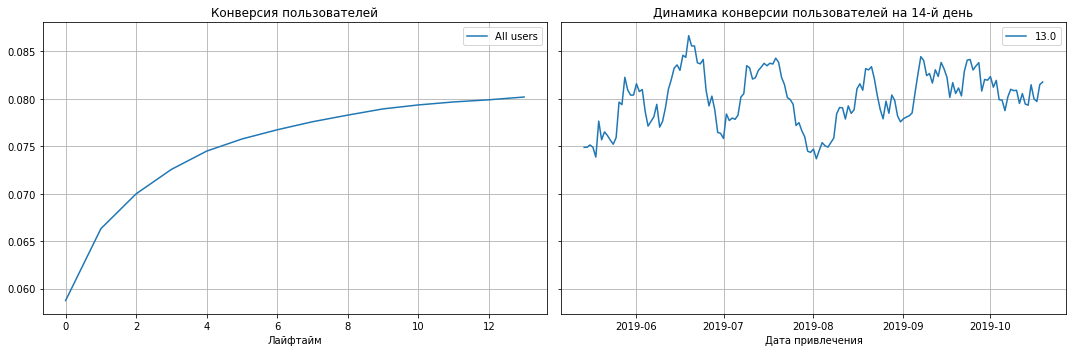

In [34]:
# считаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles.query('channel != "organic"'),
                                                                        orders,
                                                                        observation_date,
                                                                        horizon_days)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=window)

Пользователи стабильно конвертируются в покупателей. Согласно графику динамики конверсии 14-го дня, конверсия пользователей постепенно растёт с каждым месяцем.

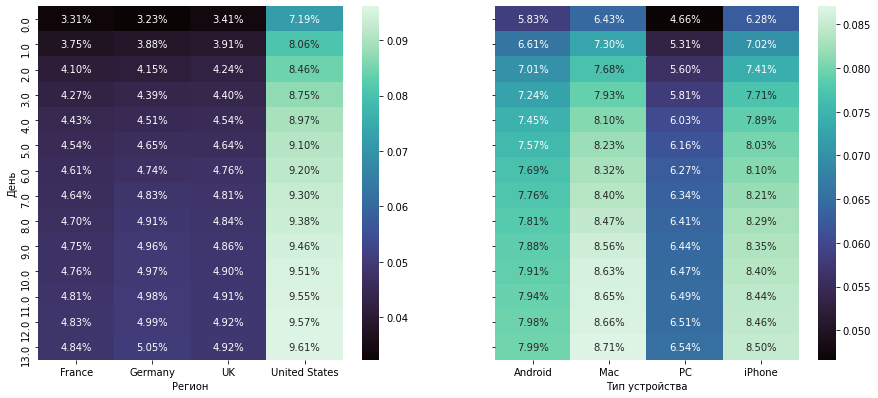

In [35]:
# посмотрим на таблицу конверсии в разбивке по странам и по устройствам
conversion_raw1, conversion1, conversion_history1 = get_conversion(profiles.query('channel != "organic"'), 
                                                                orders, 
                                                                observation_date, 
                                                                horizon_days, 
                                                                dimensions=['region'])
conversion_raw2, conversion2, conversion_history2 = get_conversion(profiles.query('channel != "organic"'), 
                                                                orders, 
                                                                observation_date, 
                                                                horizon_days, 
                                                                dimensions=['device'])

# строим хитмэп по таблице конверсии
fig, axes = plt.subplots(1, 2, figsize=(15, 6.5), sharey=True)
f1 = sns.heatmap(conversion1.drop(columns=['cohort_size']).T, 
            annot=True, fmt='.2%', annot_kws={"size": 10}, 
            cmap = "mako", 
            ax=axes[0])
f2 = sns.heatmap(conversion2.drop(columns=['cohort_size']).T, 
            annot=True, fmt='.2%', annot_kws={"size": 10}, 
            cmap = "mako", 
            ax=axes[1]) 
f1.set(xlabel='Регион')
f1.set(ylabel='День')
f2.set(xlabel='Тип устройства')
f2.set(ylabel=None)
plt.show()

По графикам можно сделать выводы:

1. Пользователи из США более чем в два раза охотнее конвертируются в покупателей: почти 7,2% новых пользователей совершают покупки в день первого посещения, а к 14-му дню доля покупателей достигает 9.61%.
2. Конверсия пользователей PC самая маленькая: 4.66% новых пользователей совершают покупки в день первого посещения, к 14-му дню доля покупателей составляет 6.5%. Для остальных платформ конверсия примерно одинаковая и к 14-му дню составляет ~8-8.5%.

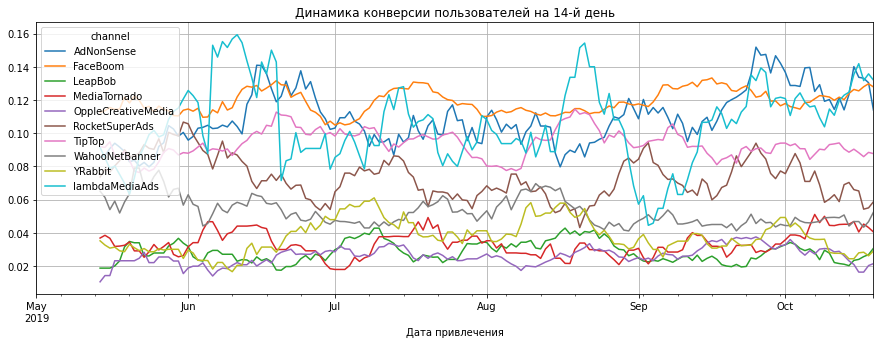

In [36]:
# посмотрим на динамику конверсии в разбивке по каналам привлечения
conversion_raw, conversion, conversion_history = get_conversion(profiles.query('channel != "organic"'), 
                                                                orders, 
                                                                observation_date, 
                                                                horizon_days, 
                                                                dimensions=['channel'])
  
conversion = conversion.drop(columns=['cohort_size'])
conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon_days - 1]]

columns = [name for name in conversion_history.index.names if name not in ['dt']] 
filtered_data = conversion_history.pivot_table(index='dt', columns=columns, values=horizon_days - 1, aggfunc='mean')
filter_data(filtered_data, window=14).plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon_days))

plt.show();

Из данных на графике видно, что в последний месяц (октябрь 2019 года) наибольшие значения конверсии пользователей на 14-ый день характерны для каналов AdNonSense, FaceBoom и lambdaMediaAds, в свою очередь каналы YRabbit, LeapBob и OppleCreativeMedia показали наихудший результат.

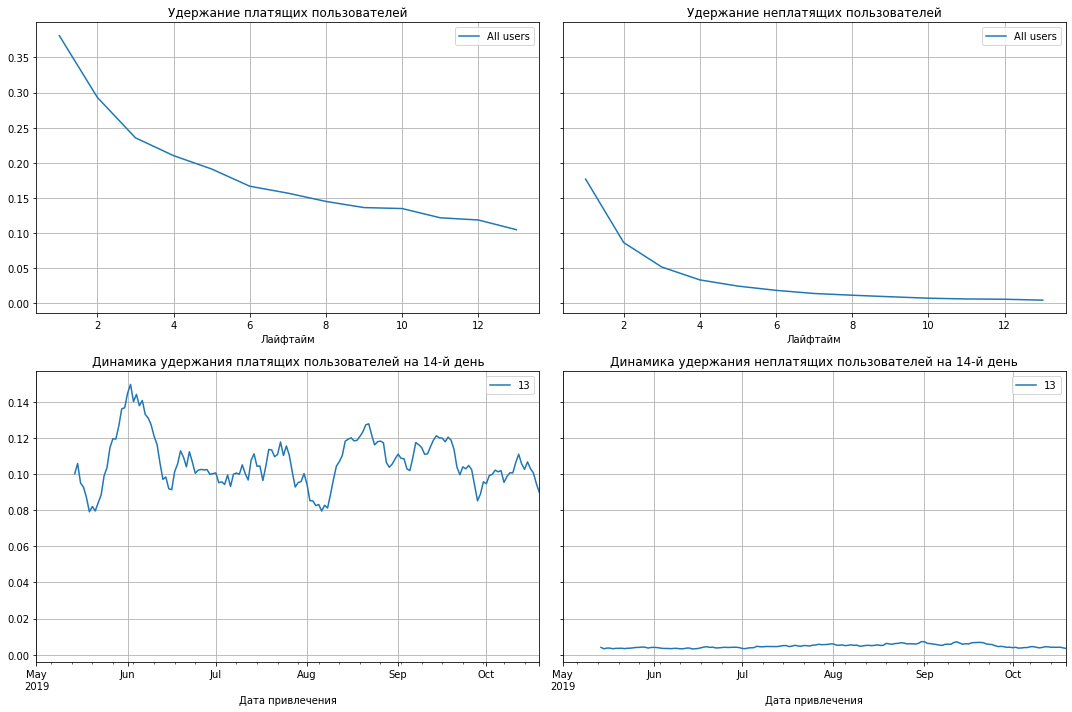

In [37]:
# считаем удержание 
retention_raw, retention_grouped, retention_history = get_retention(profiles.query('channel != "organic"'),
                                                                    visits,
                                                                    observation_date,
                                                                    horizon_days)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days, window=window)

Согласно графикам удержания, в последние месяцы (сентябрь - октябрь 2019 года) на 14-ый день в приложение возвращаются примерно 10-12% новых платящих пользователей. 

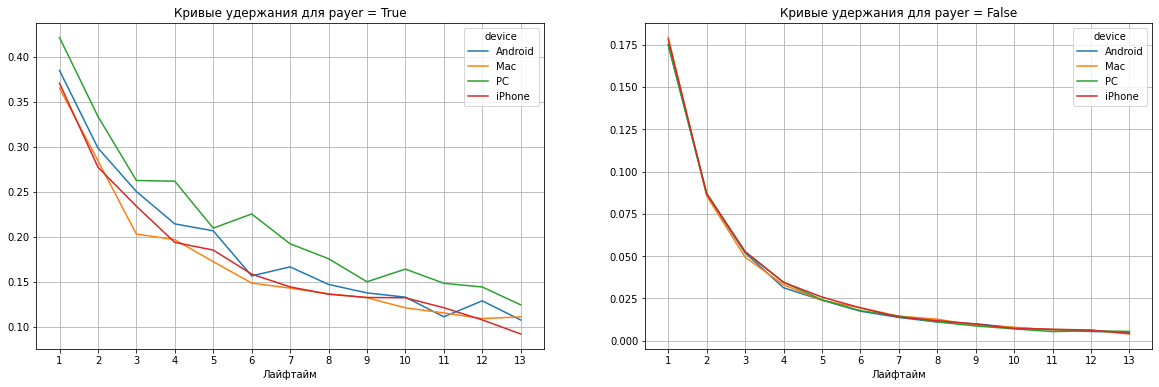

In [38]:
# посмотрим на удержание второго, седьмого и четырнадцатого дня в разбивке по типу устройства
# воспользуемся примером кода из обучающего материала, добавим сглаживание и отображение 2, 7 и 14 дней
retention_raw, retention, retention_history = get_retention(profiles.query('channel != "organic"'), 
                                                            visits, 
                                                            observation_date, 
                                                            horizon_days, 
                                                            dimensions=['device'])

# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

Самый высокий процент удержания для платящих пользователей приходится на платформу PC, для остальных платформ показатель удержания ниже, но явного аутсайдера нет.

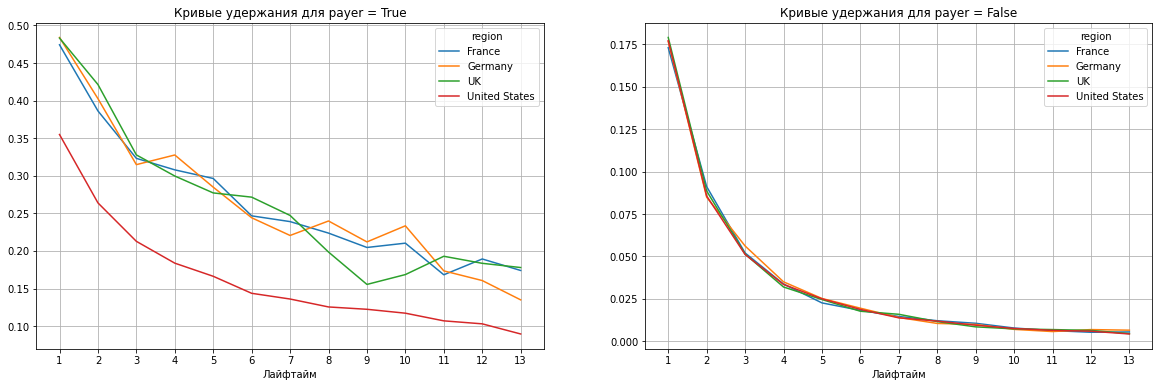

In [39]:
# посмотрим на удержание второго, седьмого и четырнадцатого дня в разбивке по странам
retention_raw, retention, retention_history = get_retention(profiles.query('channel != "organic"'), 
                                                            visits, 
                                                            observation_date, 
                                                            horizon_days, 
                                                            dimensions=['region'])

# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

Удержание платящих пользователей из Европы примерно на 5-10% выше, чем удержание платящих пользователей из США за весь анализируемый лайфтайм. Самые высокие значения удержания к 14-му дню показывают платящие пользователи из Франции и Великобритании.

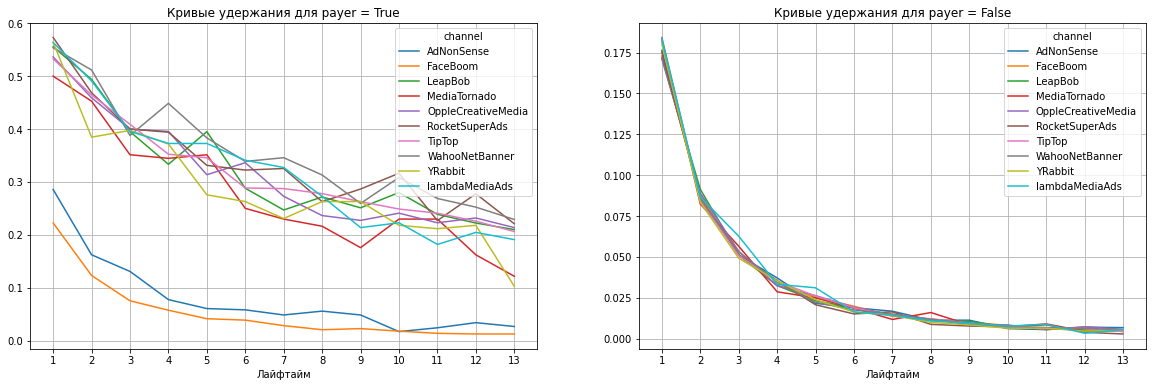

In [40]:
# посмотрим на удержание в разбивке по каналам привлечения
retention_raw, retention, retention_history = get_retention(profiles.query('channel != "organic"'), 
                                                            visits, 
                                                            observation_date, 
                                                            horizon_days, 
                                                            dimensions=['channel'])

# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])
for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

Наихудшими с точки зрения удержания платящих пользователей являются каналы AdNonSense и FaceBoom.

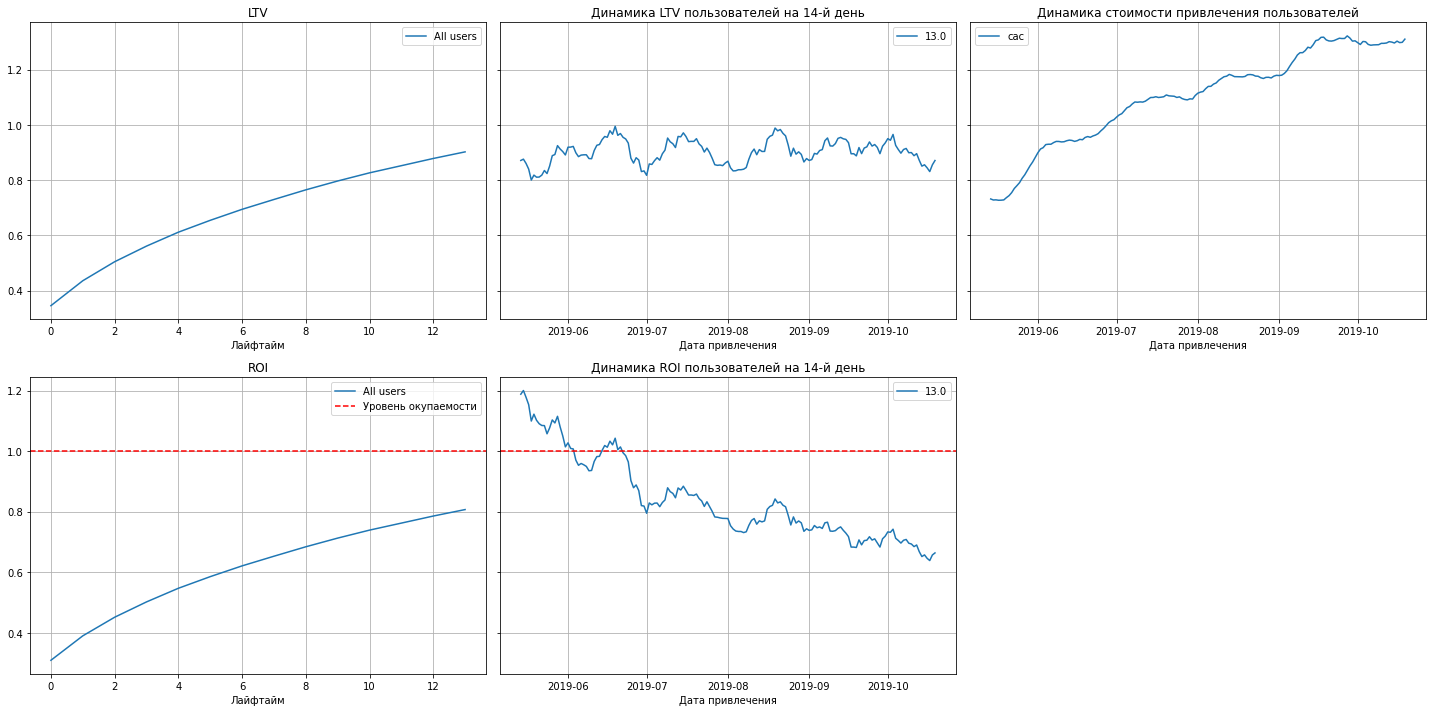

In [41]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=window) 

По графикам можно сделать следующие выводы:
1. Реклама не окупается. ROI в конце второй недели так и не доходит до 1. При этом, если до июля 2019 года реклама себя окупала, то в последние месяцы (июль-октябрь) возврата инвестиций не происходит.
2. CAC растет с каждым месяцес, бютжет на рекламу увеличивается.
3. LTV достаточно стабилен, можно заключить, что "качество пользователей" не ухудшилось со временем.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — типу устройства, стране и источнику привлечения трафика.

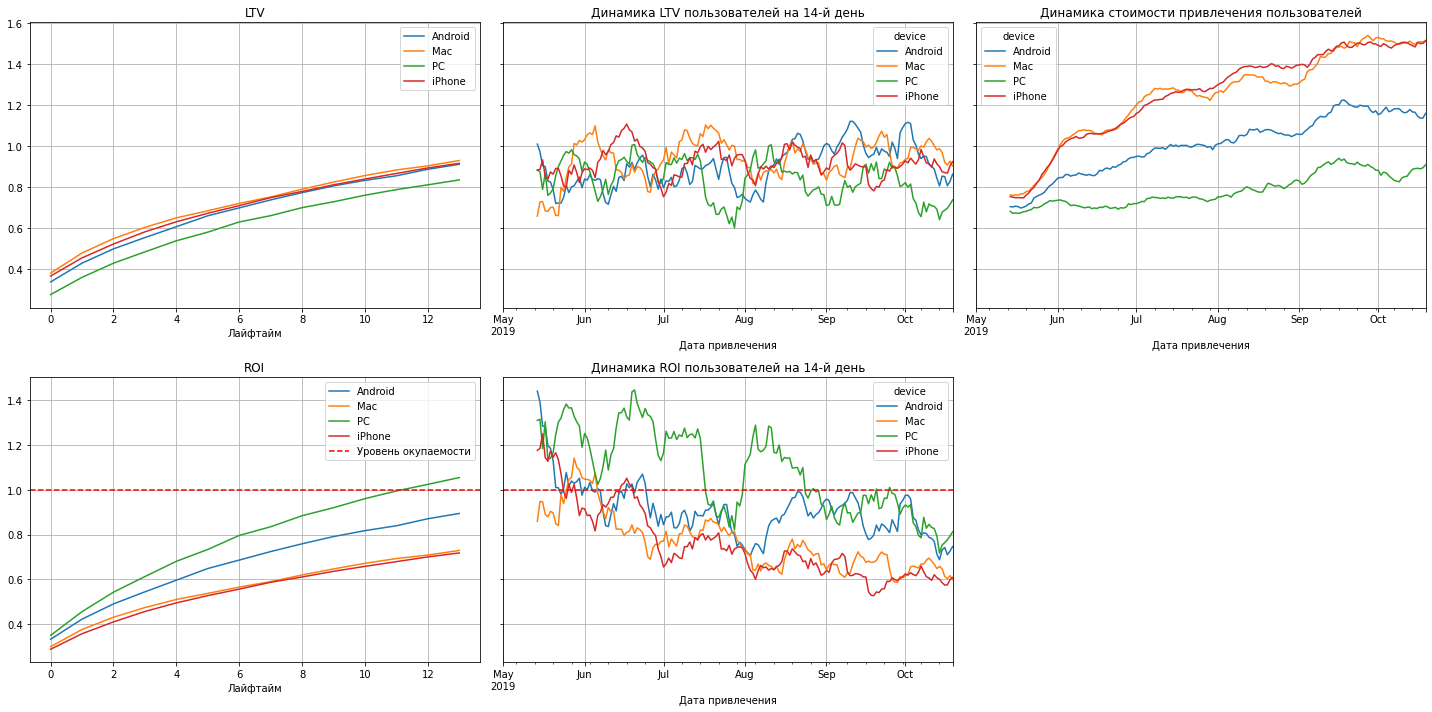

In [42]:
# проанализируем окупаемость рекламы с разбивкой по устройствам
dimension = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, 
                                                                      dimensions=dimension)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=window) 

Проанализировав окупаемость с разбивкой по типам устройств можно заключить:
1. LTV для всех платформ стабилен.
2. Стоимость привлечения пользователей для всех типов устройст растет.
3. Динамика ROI на 14-ый день неутешительная, окупаемость по всем каналам падает.
4. Полизователи Mac и iPhone являются самыми дорогими с точки зрения привлечения, при этом они абсолютно не опупаются. 
5. В связи с увеличением стоимости привлечения пользователей на PC к сентябрю 2019 года последние также перестали окупаться. 

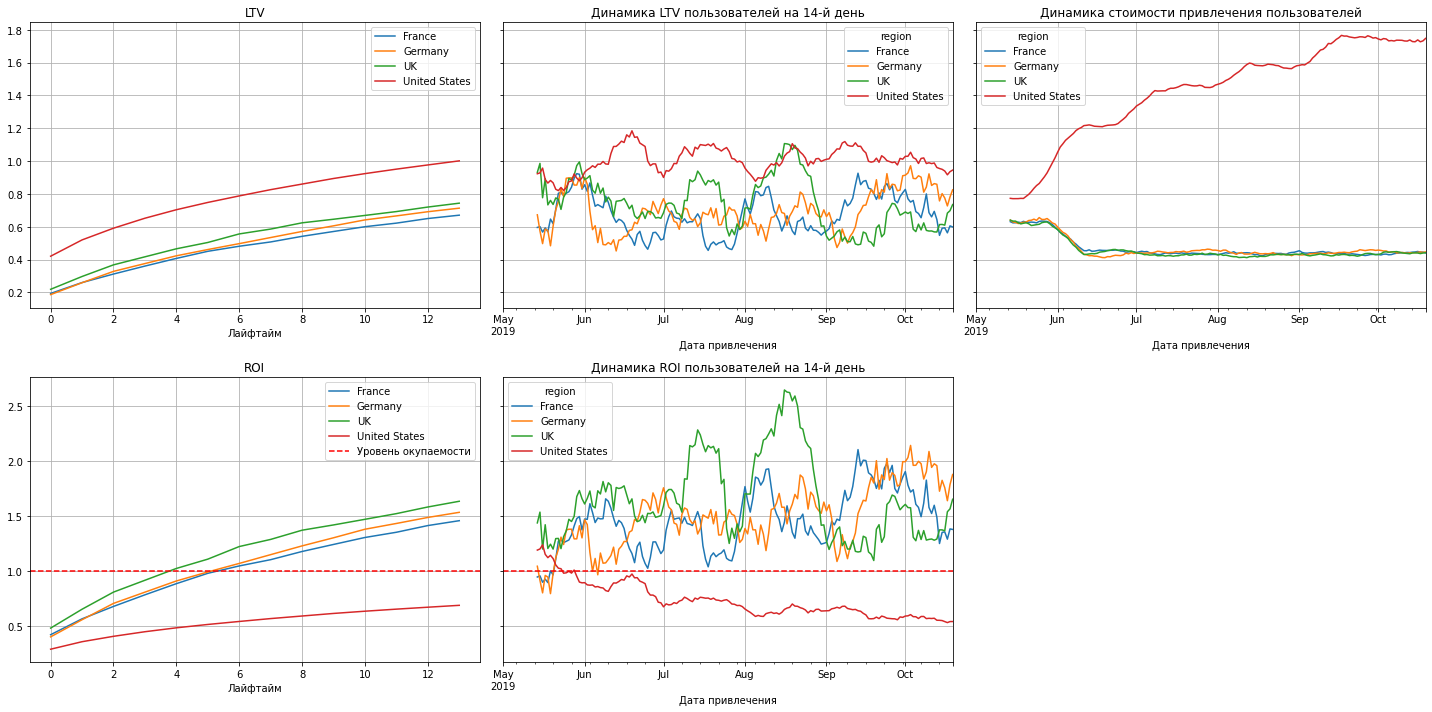

In [43]:
# проанализируем окупаемость рекламы с разбивкой по странам
dimension = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, 
                                                                      dimensions=dimension)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=window) 

Проанализировав окупаемость с разбивкой по странам можно заключить:

1. LTV для всех стран относительно стабилен, однако пожизненная ценность клиентов из США выше, чем в других странах.
2. Стоимость привлечения пользователей из США на порядок выше стоимости привлечения пользователей из других регионов. САС для пользователей из США растет.
3. Пользователи из США себя не окупают (ROI 14-го дня < 1), в то время как ROI 14-го дня для пользователей из других стран обычно не опускается ниже 1.

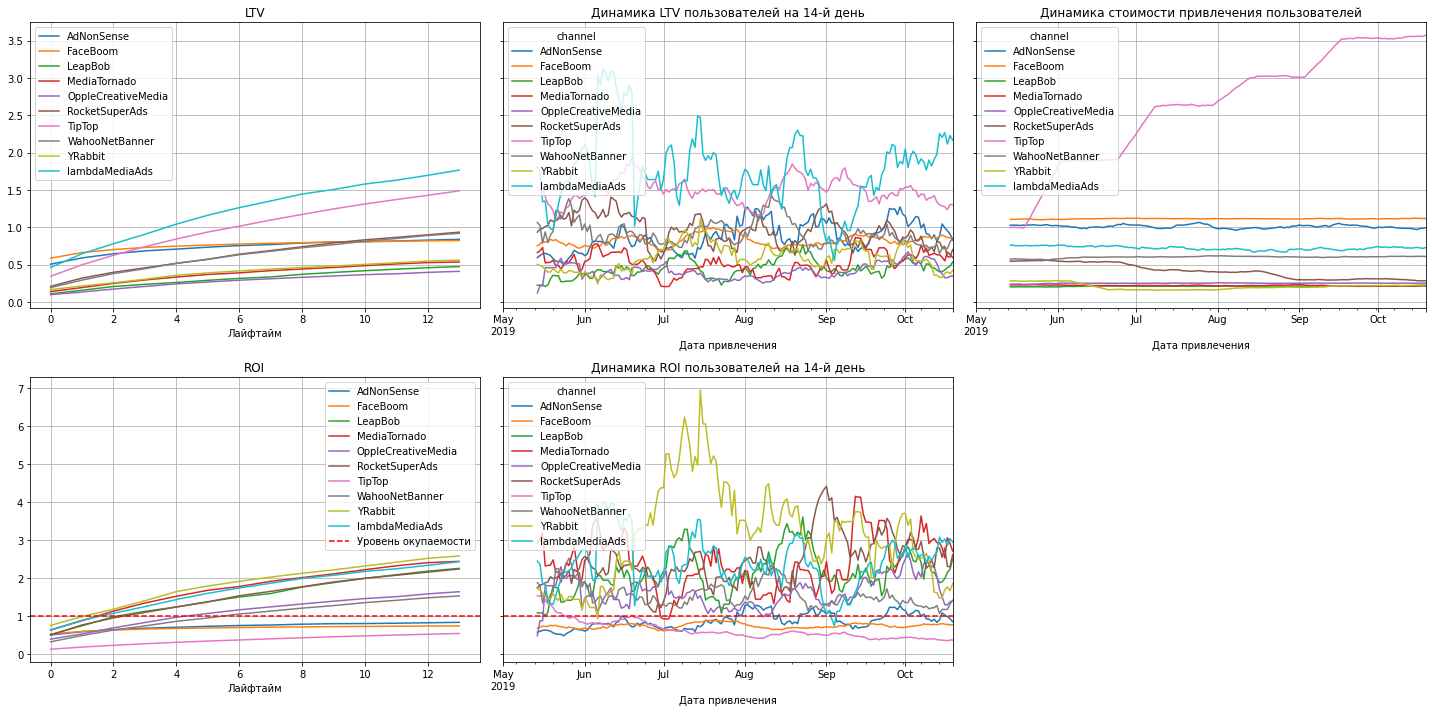

In [44]:
# проанализируем окупаемость рекламы с разбивкой по каналам привлечения
dimension = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles.query('channel != "organic"'), 
                                                                      orders, 
                                                                      observation_date, 
                                                                      horizon_days, 
                                                                      dimensions=dimension)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=window) 

Проанализировав окупаемость с разбивкой по каналам привлечения можно заключить:

1. Значения LTV наибольшие для каналов lambdaMediaAds и TipTop. За исключением lambdaMediaAds, LTV для всех остальных каналов относительно стабилен.
2. САС для канала TipTop сильно завышена и выбивается на фоне всех остальных каналов привлечения новых пользователей.
3. Динамика ROI 14-го дня показывает, что привлечение через каналы TipTop, AdNonSense и FaceBoom себя не окупает.
4. Значения ROI 14-го дня для каналов lambdaMediaAds, MediaTornado, LeapBob и RocketSuperAds лежат в пределах 2-3.

<div style="border-radius: 15px; background:BlanchedAlmond; padding: 20px">

📜 Итог оценки окупаемости рекламы:
- В целом, реклама, направленная на привлечение новых пользователей не окупается.
- Пользователи стабильно конвертируются в покупателей. При этом пользователи из США более чем в два раза охотнее конвертируются в покупателей.
- Конверсия к 14-му дню для всех платформ кроме PC примерно одинаковая и составляет ~8-8.5%, для PC этот показатель на 20% ниже.
- Удержание немного падает со временеи и в последние месяцы (сентябрь - октябрь 2019 года) на 14-ый день в приложение возвращаются примерно 10-12% новых платящих пользователей.
- Значение удержания для платящих пользователей из США ниже, чем таковое для пользователей из Европы.
- Наихудшими с точки зрения удержания платящих пользователей являются каналы AdNonSense и FaceBoom.
- Негативное влияние на окупаемость рекламы оказывают:
    1. Полизователи Mac и iPhone, которые являются самыми дорогими с точки зрения привлечения, но при этом они абсолютно не опупаются.
    2. Пользователи из реиона США, для которых ROI 14-го дня меньше 1.
    3. Пользователи, привлеченные через каналы TipTop, AdNonSense и FaceBoom, которые себя не окупает.
- Наибольшие расходы на маркетинг приходятся на два канала - TipTop и FaceBoom, при этом данные показываю, что новые пользователи, пришедшие через эти каналы привлечения себя не окупают.	
- Привлечение пользователей из США обходится слишком дорого, в то время как привлечение пользователей из других регионов не такое масштабное (если судить по общему количесву новых пользователей), хотя привлечение таких пользователей могло бы потенциально принести больше прибыли.

</div>

### Общий вывод

<div style="border-radius: 15px; background:BlanchedAlmond; padding: 20px">
    
Предоставленные для анализа данные маркетинговый аналитики развлекательного приложения Procrastinate Pro+ были предварительно обработаны перед работой: 
+ изменены названия столбцов;
+ преобразованы тип данных для столбцов 'session_start', 'session_end', 'event_dt' и 'dt' в тип 'datetime64[ns]'.

<br>
В результате представленного исследования были выделены причины неэффективности привлечения пользователей:

1. **Два ключевых канала привлечения новых пользователей - TipTop и FaceBoom - себя не окупают: у TipTop постоянно возрастает САС, у FaceBoom низкие значения удержания платящих пользователей**
2. **Четвертый по затратам на маркетинг канал привлечения - AdNonSense - также характеризуется очень низким значением удержания платящих пользователей и переменной окупаемостью затрат на рекламу**
3. **Высокие затраты на привлечение пользователей из США при низких значениях удержания для платящих пользователей из этого региона**
4. **Высокие затраты на привлечение пользователей на устройствах типа Mac и iPhone, ситуация усугубляется не самыми высокими показателями удержания платящих пользователей для этих платформ**
    
<br>
Сформулированы следующие рекомендации для отдела маркетинга: 

+ Сделать акцент на привлечение новых пользователей из Европы, а не из США.
+ Отказаться или сильно сократить маркетинговые расходы на привлечение пользователей через TipTop, AdNonSense и FaceBoom, так как по показателю ROI к 14-му дню эти каналы себя не окупают.
+ Обратить внимание на такой канал привлечения пользователей как lambdaMediaAds, который характеризуется высоким значение доли привлеченных новых платящих пользователей (10.47%), относительно невысоким значением САС (~0.7) и, при этом, лучшими показателями LTV и ROI 14-го среди всех каналов привлечения.
+ Перспективными каналами привлечения также могут стать RocketSuperAds (для региона США) и WahooNetBanner (для региона Европа), они стабильно окупаются, характеризуются высокими значениями удержания и не самой плохой конверсивей.
+ Сократить расходы на привлечение клиентов на устройствах типа Mac и iPhone, вместо этого сделать акцент на привлечение пользователей Android и PC, чтобы увеличсить долю платящих пользователей на этих платформах.
    
</div>